In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib import colors as mcolors

In [23]:
log_dir = "./logs"
log_folder = os.listdir(log_dir)

all_runs = []
for folder in log_folder:
    data = pd.read_csv(os.path.join(log_dir, folder, "metrics.csv"))
    data["run"] = folder
    all_runs.append(data)

all_runs = pd.concat(all_runs)
all_runs["run"] = all_runs["run"].astype("category")



In [24]:
all_runs.head()

,Unnamed: 0,time_training,iteration,distortion,silhouette,davies_bouldin,calinski_harabasz,run
0,0,0.625015,0,2.493406e+09,0.164766,1.732474,14.456796,[SK_HAC]_[att]_22th12mo_01h25min50s_seed859
0,0,0.249934,0,5.071745e+04,0.058907,2.752391,18.587351,[SK_HAC]_[ba]_22th12mo_02h02min28s_seed182
0,0,15053.753548,0,7.287649e+06,NaN,NaN,NaN,[SK_HAC]_[cifar10]_22th12mo_01h15min21s_seed87
0,0,0.174886,0,1.930186e+08,0.207856,1.795867,86.591526,[SK_HAC]_[coil]_22th12mo_02h20min59s_seed905
0,0,0.103555,0,7.885144e+01,0.552819,0.661972,561.627724,[SK_HAC]_[iris]_22th12mo_05h45min26s_seed902


In [25]:
all_runs.drop(columns=["Unnamed: 0"], inplace=True)

In [26]:
all_runs.head()

,time_training,iteration,distortion,silhouette,davies_bouldin,calinski_harabasz,run
0,0.625015,0,2.493406e+09,0.164766,1.732474,14.456796,[SK_HAC]_[att]_22th12mo_01h25min50s_seed859
0,0.249934,0,5.071745e+04,0.058907,2.752391,18.587351,[SK_HAC]_[ba]_22th12mo_02h02min28s_seed182
0,15053.753548,0,7.287649e+06,NaN,NaN,NaN,[SK_HAC]_[cifar10]_22th12mo_01h15min21s_seed87
0,0.174886,0,1.930186e+08,0.207856,1.795867,86.591526,[SK_HAC]_[coil]_22th12mo_02h20min59s_seed905
0,0.103555,0,7.885144e+01,0.552819,0.661972,561.627724,[SK_HAC]_[iris]_22th12mo_05h45min26s_seed902


In [27]:
import re

pattern = r"\[(.*?)\]_\[(.*?)\]"
pattern = re.compile(pattern)

def extract_run_info(run_id: str):
    unique_id = hash(run_id)
    match = pattern.search(run_id)
    if match:
        return match.group(1), match.group(2), unique_id
    else:
        return None, None, unique_id

In [28]:
infos = [extract_run_info(run_id) for run_id in all_runs["run"]]
all_runs["algorithm"] = [info[0] for info in infos]
all_runs["dataset"] = [info[1] for info in infos]
all_runs["run_id"] = [info[2] for info in infos]

In [29]:
all_runs.head()

,time_training,iteration,distortion,silhouette,davies_bouldin,calinski_harabasz,run,algorithm,dataset,run_id
0,0.625015,0,2.493406e+09,0.164766,1.732474,14.456796,[SK_HAC]_[att]_22th12mo_01h25min50s_seed859,SK_HAC,att,2007124970954256897
0,0.249934,0,5.071745e+04,0.058907,2.752391,18.587351,[SK_HAC]_[ba]_22th12mo_02h02min28s_seed182,SK_HAC,ba,366604092044935952
0,15053.753548,0,7.287649e+06,NaN,NaN,NaN,[SK_HAC]_[cifar10]_22th12mo_01h15min21s_seed87,SK_HAC,cifar10,-7042851199435042625
0,0.174886,0,1.930186e+08,0.207856,1.795867,86.591526,[SK_HAC]_[coil]_22th12mo_02h20min59s_seed905,SK_HAC,coil,3079329783959834365
0,0.103555,0,7.885144e+01,0.552819,0.661972,561.627724,[SK_HAC]_[iris]_22th12mo_05h45min26s_seed902,SK_HAC,iris,-202420175083338440


In [30]:
run_ids = all_runs["run_id"].unique()
datasets = all_runs["dataset"].unique()
algorithms = all_runs["algorithm"].unique()

print("Number of runs:", len(run_ids))
print("Number of datasets:", len(datasets))
print("Number of algorithms:", len(algorithms))

Number of runs: 252
Number of datasets: 6
Number of algorithms: 6


In [31]:
all_runs = all_runs.sort_values(by=['run_id', 'iteration'])
all_runs["best_distortion"] = all_runs.groupby("run_id")["distortion"].cummin()
all_runs["best_silhouette"] = all_runs.groupby("run_id")["silhouette"].cummax()
all_runs["best_davies_bouldin"] = all_runs.groupby("run_id")["davies_bouldin"].cummin()
all_runs["best_calinski_harabasz"] = all_runs.groupby("run_id")["calinski_harabasz"].cummax()

In [32]:
def metric_string(metric_name: str):
    return " ".join([c.capitalize() for c in metric_name.split("_")]) + " Score"

In [33]:
print(datasets)

['att' 'ba' 'cifar10' 'coil' 'iris' 'mnist']


In [137]:
os.makedirs("./plots", exist_ok=True)

In [20]:
def plot_dataset(dataset, save=False):
    print("Dataset:", dataset)
    data_dataset = all_runs[all_runs["dataset"] == dataset]
    print("Number of runs:", len(data_dataset["run_id"].unique()))

    nb_iterations = [data_dataset[data_dataset["run_id"] == run_id]["iteration"].max() + 1 for run_id in data_dataset["run_id"].unique()]
    print("Number of iterations:", nb_iterations)
    max_iterations = max(nb_iterations)

    colors = list(mcolors.TABLEAU_COLORS.keys())

    metrics = data_dataset.columns[data_dataset.notna().any()].drop(["run", "algorithm", "dataset", "run_id", "time_training", "iteration"]).to_list()
    metrics = list(filter(lambda x: x.startswith("best"), metrics))

    mean_iterations_time = data_dataset.groupby(["algorithm"])["time_training"].mean()

    for k, algorithm in enumerate(filter(lambda x: x != "SK_HAC" and x != "SK_KKZ", algorithms)):
        if algorithm == "SK_PCA_GuidedSearch":
            title = "PCA"
        else:
            title = algorithm[3:]
        plt.bar(title, mean_iterations_time[algorithm], color=colors[k])
    plt.bar("HAC", mean_iterations_time["SK_HAC"], color=colors[k+2])
    plt.bar("KKZ", mean_iterations_time["SK_KKZ"], color=colors[k+1])
    plt.ylabel("Mean training time (s)")
    plt.title("Mean training time for different algorithms on dataset {}".format(dataset))
    if save:
        plt.savefig("./plots/{}_time.png".format(dataset), dpi=300)
    plt.show()

    for k, algorithm in enumerate(filter(lambda x: x != "SK_HAC" and x != "SK_KKZ", algorithms)):
        if algorithm == "SK_PCA_GuidedSearch":
            title = "PCA"
        else:
            title = algorithm[3:]
        plt.bar(title, mean_iterations_time[algorithm], color=colors[k])
    plt.ylabel("Mean training time (s)")
    plt.title("Mean training time for different algorithms on dataset {}".format(dataset))
    if save:
        plt.savefig("./plots/{}_time_zoom.png".format(dataset), dpi=300)
    plt.show()

    max_time = mean_iterations_time.drop(["SK_HAC", "SK_KKZ"]).max() * max_iterations

    for metric in metrics:
        means = data_dataset.groupby(["algorithm", "iteration"])[metric].mean()
        stds = data_dataset.groupby(["algorithm", "iteration"])[metric].std()

        mean = np.mean(means)
        std = np.std(means)
        
        for k, algorithm in enumerate(filter(lambda x: x != "SK_HAC" and x != "SK_KKZ", algorithms)):
            if algorithm == "SK_PCA_GuidedSearch":
                title = "PCA"
            else:
                title = algorithm[3:]
            plt.plot(means[algorithm].index, means[algorithm], label=title, color=colors[k])
            plt.fill_between(means[algorithm].index, means[algorithm] - stds[algorithm], means[algorithm] + stds[algorithm], alpha=0.1, color=colors[k])
        plt.plot([0, max_iterations-1], [means["SK_HAC"][0], means["SK_HAC"][0]], label="HAC", linestyle="--", color=colors[k+1])
        plt.plot([0, max_iterations-1], [means["SK_KKZ"][0], means["SK_KKZ"][0]], label="KKZ", linestyle="--", color=colors[k+2])
        plt.legend()
        plt.xlabel("Iterations")
        plt.ylabel(metric_string(metric))
        plt.title("{} evolution for different algorithms on dataset {}".format(metric_string(metric), dataset))
        if save:
            plt.savefig("./plots/{}_{}.png".format(dataset, metric), dpi=300)
        plt.show()

        for k, algorithm in enumerate(filter(lambda x: x != "SK_HAC" and x != "SK_KKZ", algorithms)):
            if algorithm == "SK_PCA_GuidedSearch":
                title = "PCA"
            else:
                title = algorithm[3:]
            plt.plot(means[algorithm].index, means[algorithm], label=title, color=colors[k])
            plt.fill_between(means[algorithm].index, means[algorithm] - stds[algorithm], means[algorithm] + stds[algorithm], alpha=0.2, color=colors[k])
        plt.plot([0, max_iterations-1], [means["SK_HAC"][0], means["SK_HAC"][0]], label="HAC", linestyle="--", color=colors[k+1])
        plt.plot([0, max_iterations-1], [means["SK_KKZ"][0], means["SK_KKZ"][0]], label="KKZ", linestyle="--", color=colors[k+2])
        plt.legend()
        plt.ylim(mean - 3*std, mean + 3*std)
        plt.xlabel("Iterations")
        plt.ylabel(metric_string(metric))
        plt.title("{} evolution for different algorithms on dataset {}".format(metric_string(metric), dataset))
        if save:
            plt.savefig("./plots/{}_{}_zoom.png".format(dataset, metric), dpi=300)
        plt.show()

        for k, algorithm in enumerate(filter(lambda x: x != "SK_HAC" and x != "SK_KKZ", algorithms)):
            if algorithm == "SK_PCA_GuidedSearch":
                title = "PCA"
            else:
                title = algorithm[3:]
            plt.plot((means[algorithm].index+1) * mean_iterations_time[algorithm], means[algorithm], label=title, color=colors[k])
            plt.fill_between((means[algorithm].index+1) * mean_iterations_time[algorithm], means[algorithm] - stds[algorithm], means[algorithm] + stds[algorithm], alpha=0.2, color=colors[k])

        if mean_iterations_time["SK_HAC"] < max_time:
            plt.plot([mean_iterations_time["SK_HAC"], max_time], [means["SK_HAC"][0], means["SK_HAC"][0]], label="HAC", linestyle="--", color=colors[k+1])
        if mean_iterations_time["SK_KKZ"] < max_time:
            plt.plot([mean_iterations_time["SK_KKZ"], max_time], [means["SK_KKZ"][0], means["SK_KKZ"][0]], label="KKZ", linestyle="--", color=colors[k+2])
        plt.legend()
        plt.ylim(mean - 3*std, mean + 3*std)
        plt.xlabel("Time (s)")
        plt.ylabel(metric_string(metric))
        plt.title("{} evolution for different algorithms on dataset {}".format(metric_string(metric), dataset))
        if save:
            plt.savefig("./plots/{}_{}_time.png".format(dataset, metric), dpi=300)
        plt.show()

Dataset: att
Number of runs: 42
Number of iterations: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1, 1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


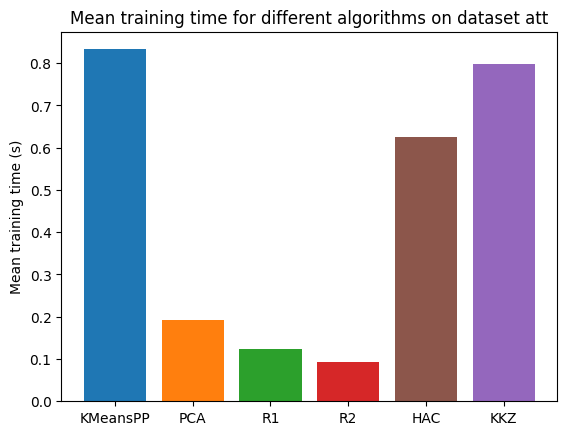

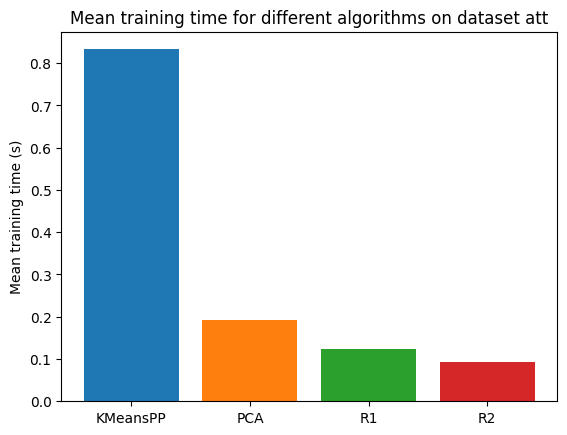

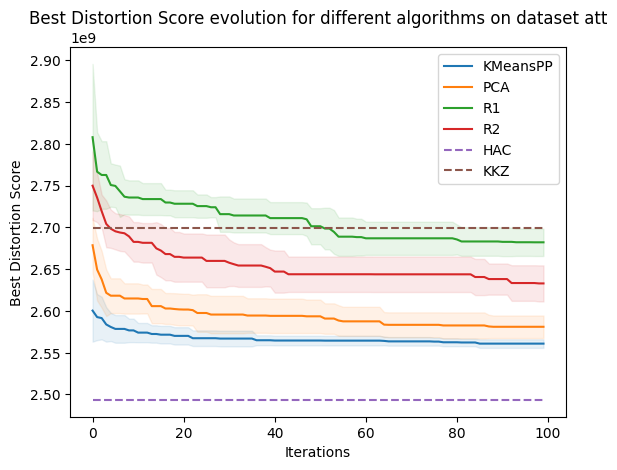

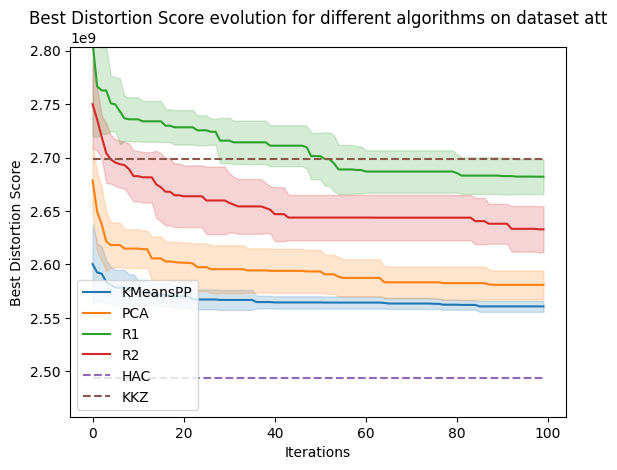

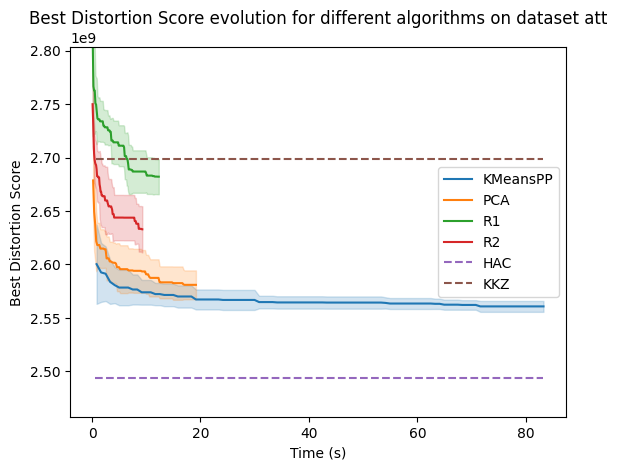

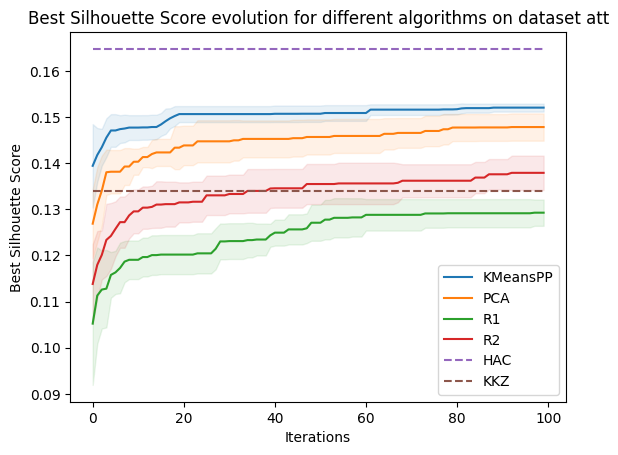

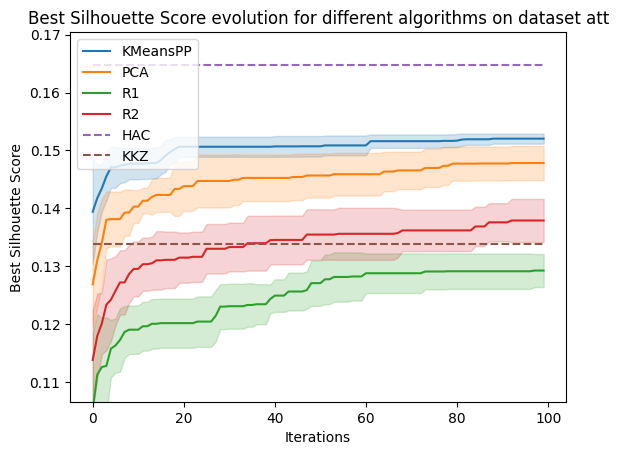

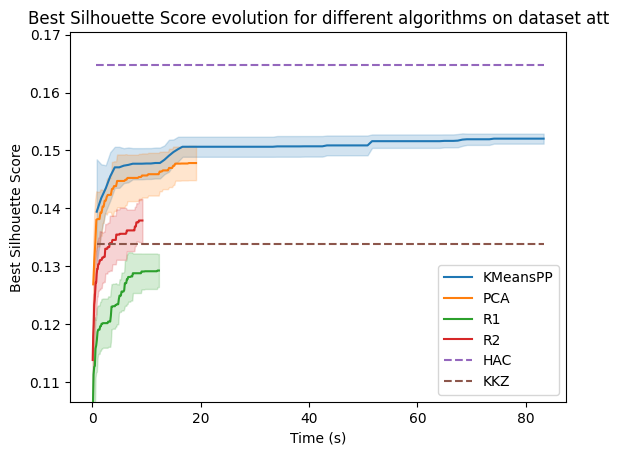

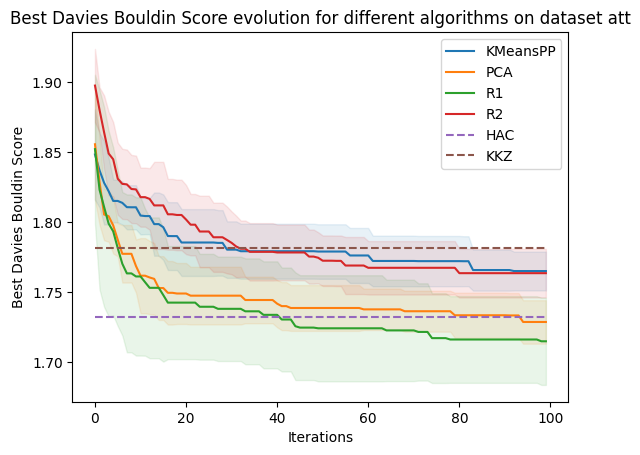

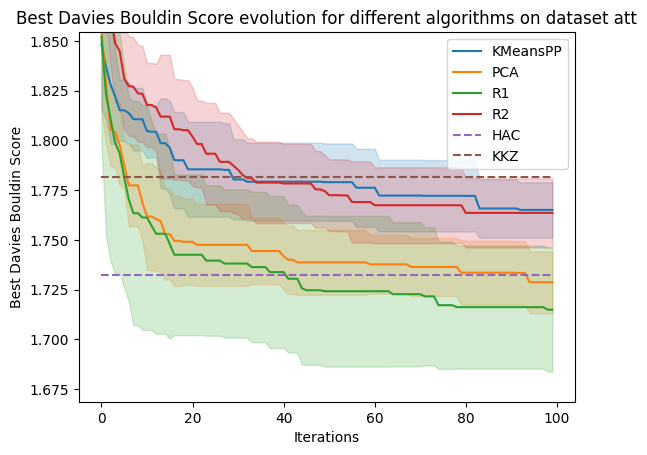

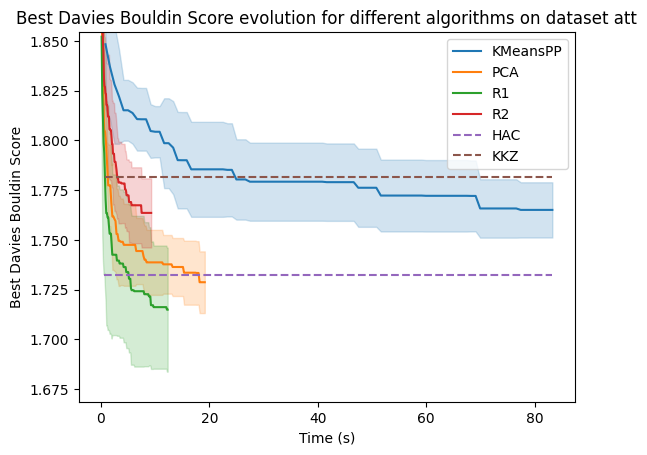

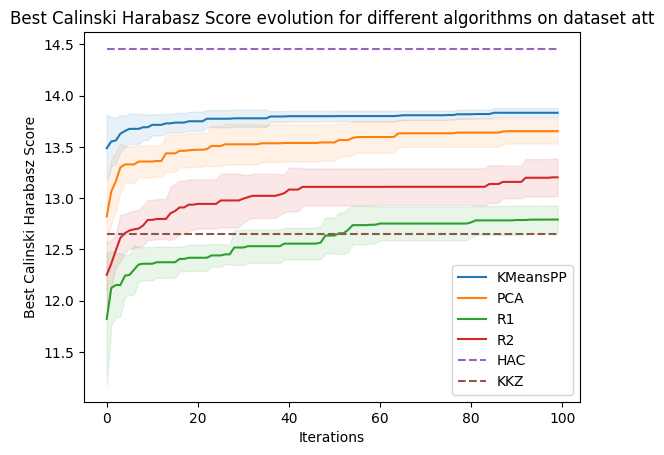

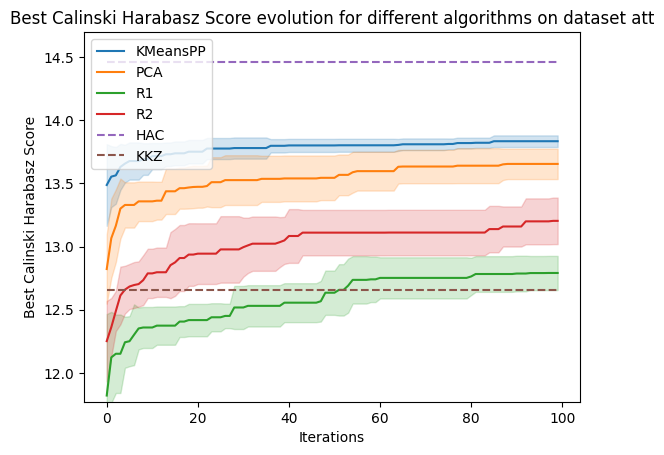

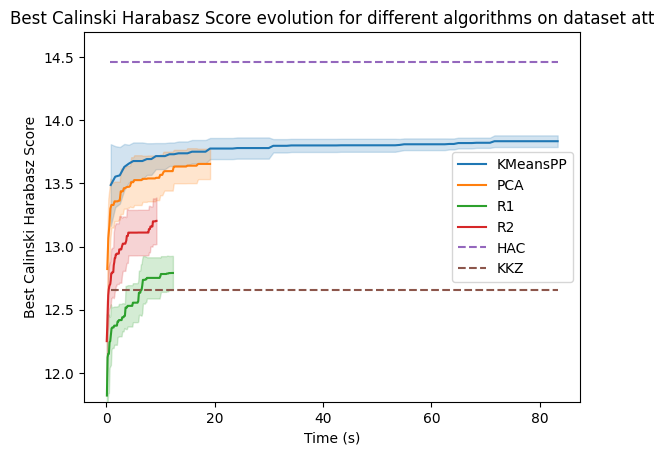

Dataset: ba
Number of runs: 42
Number of iterations: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1, 1000, 1000, 1000, 1000, 1000, 1000, 1, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


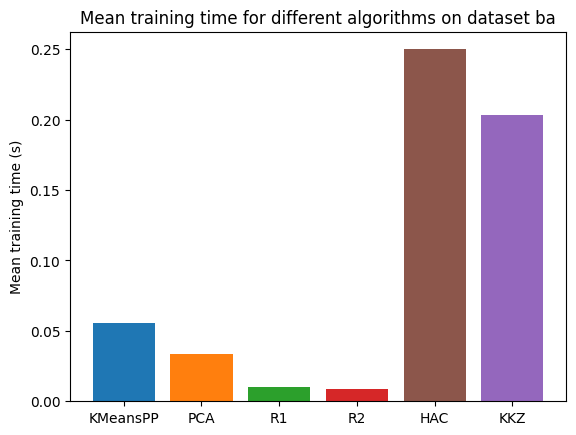

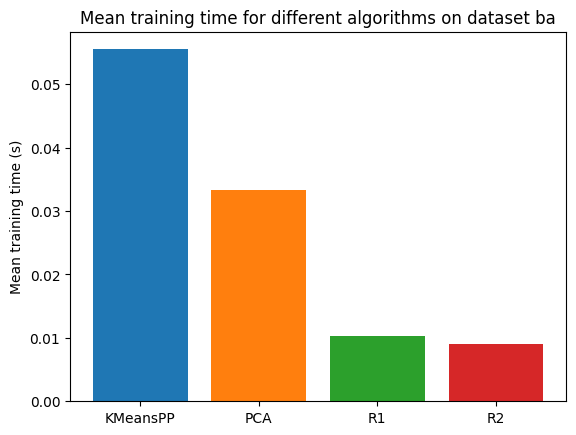

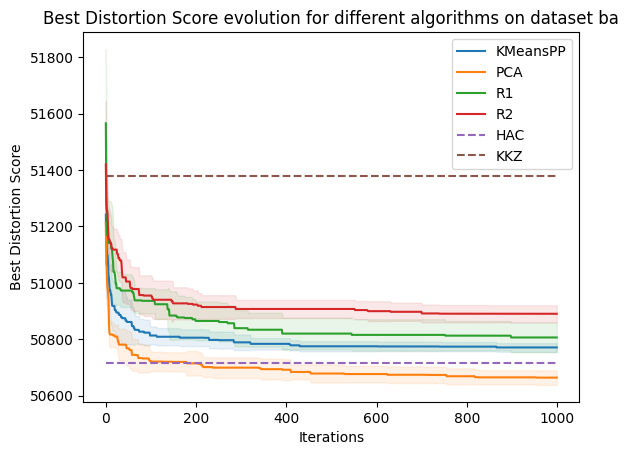

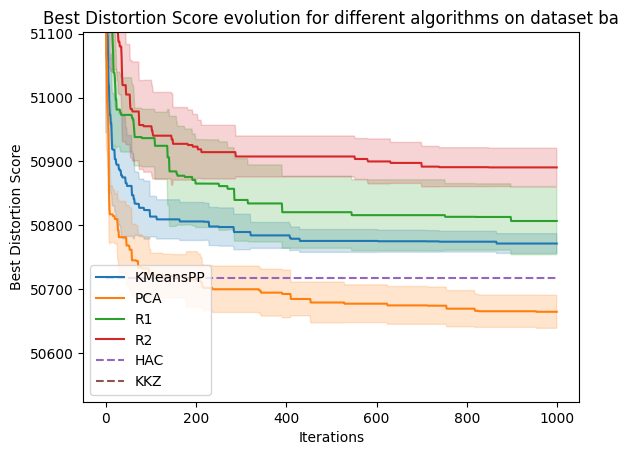

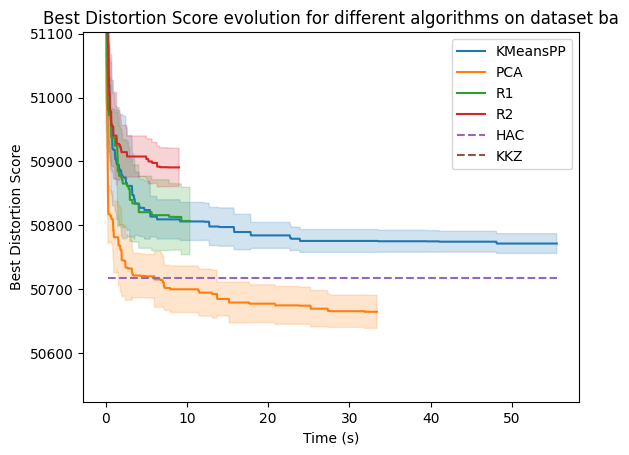

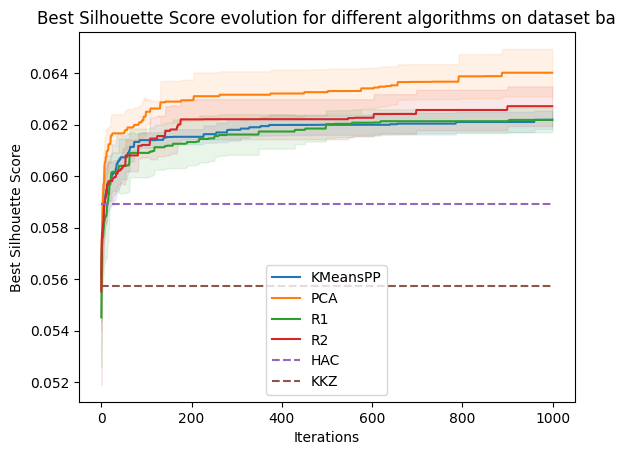

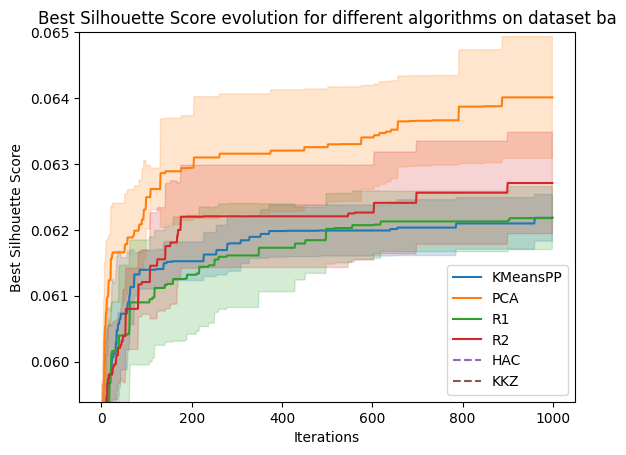

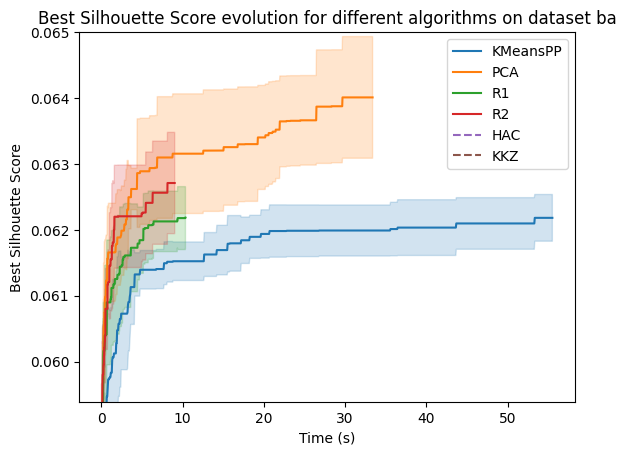

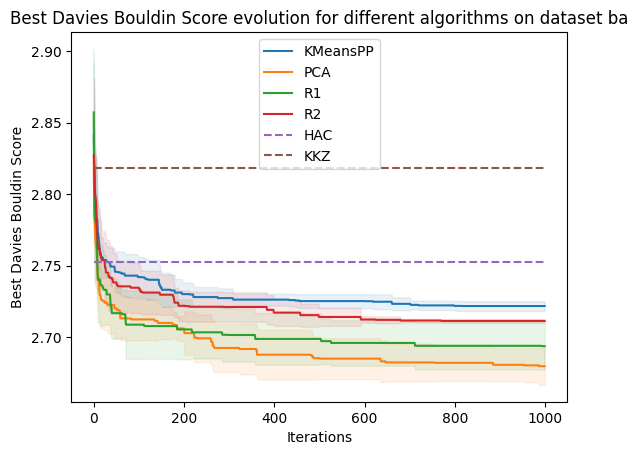

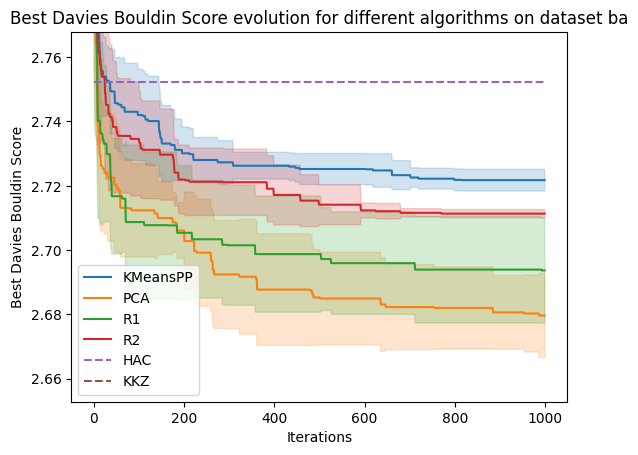

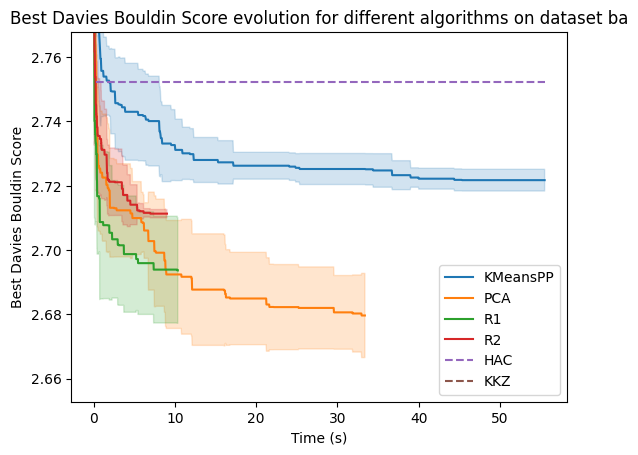

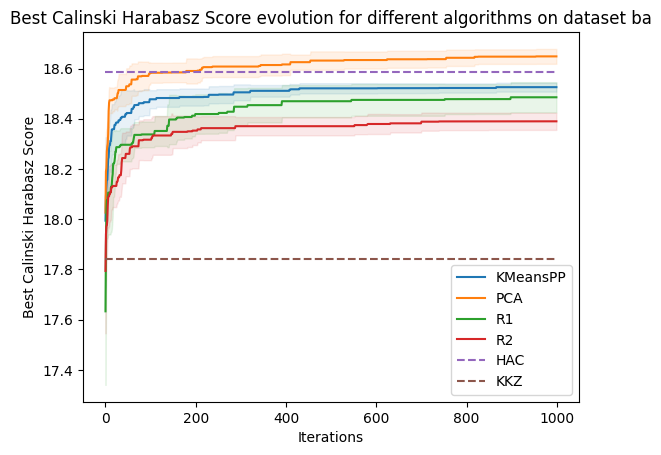

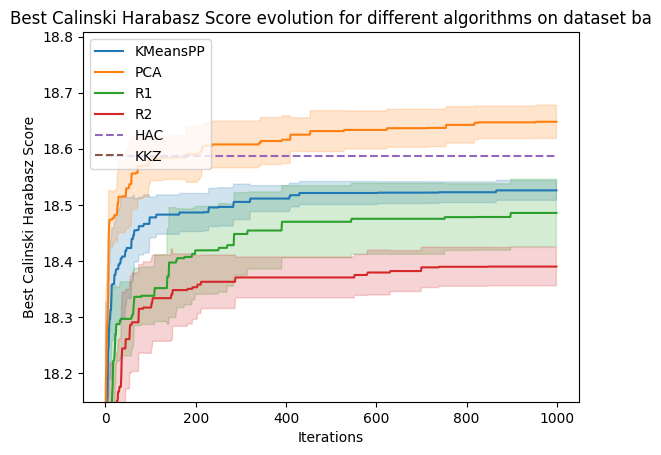

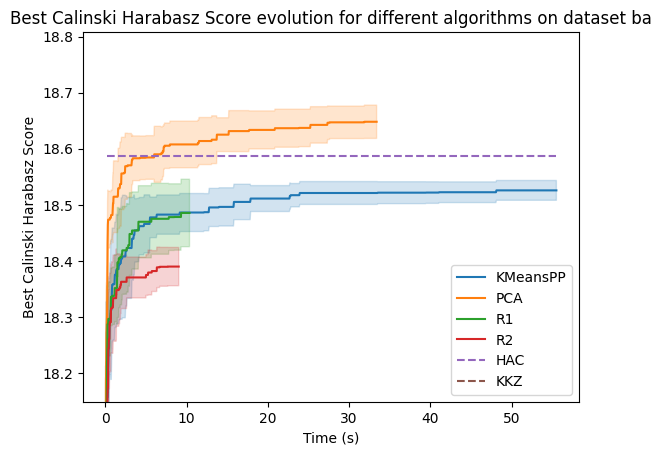

Dataset: cifar10
Number of runs: 42
Number of iterations: [4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4]


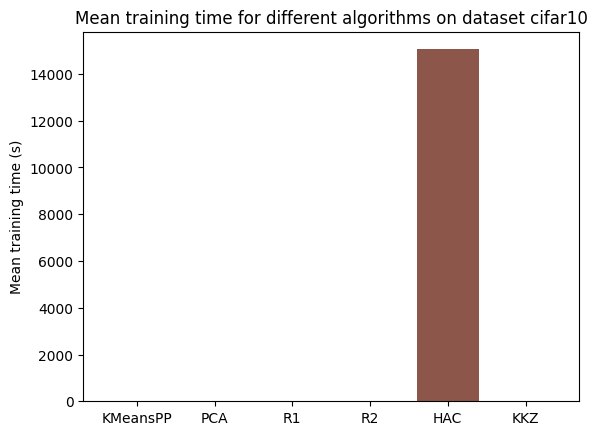

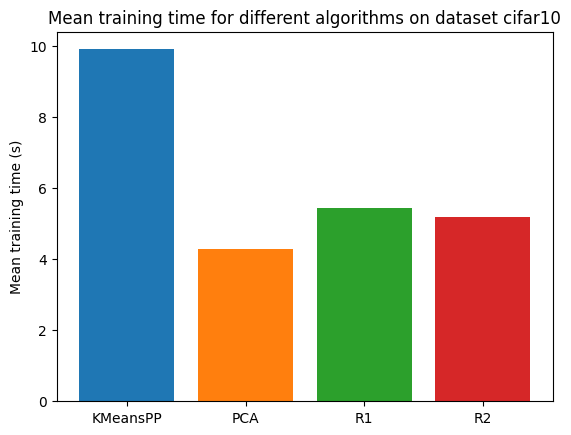

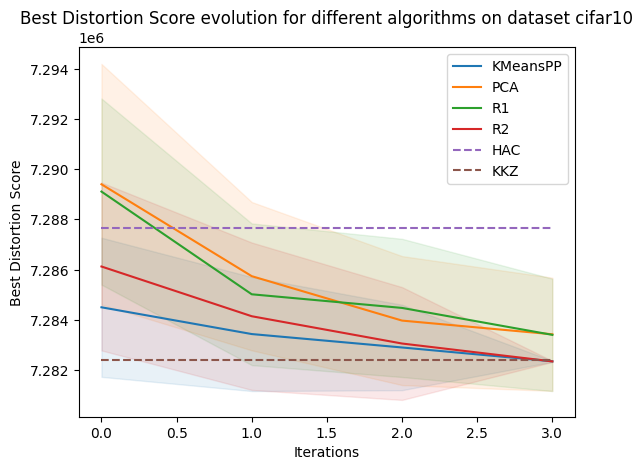

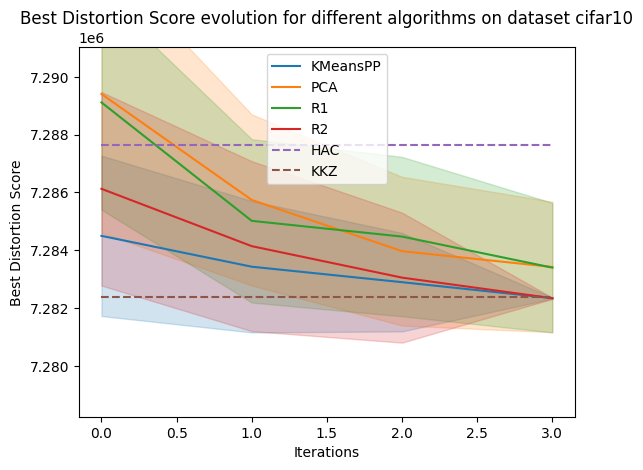

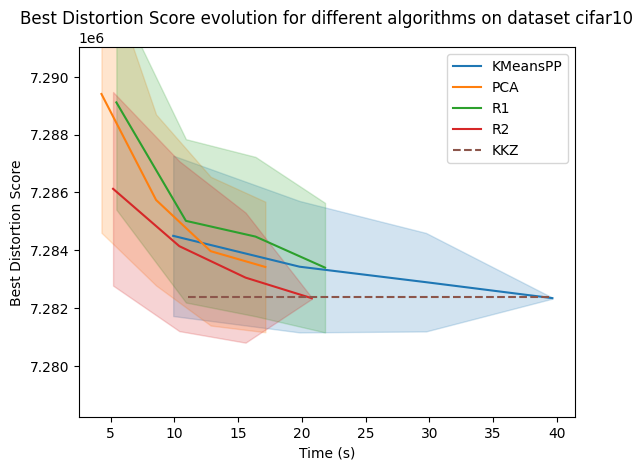

Dataset: coil
Number of runs: 42
Number of iterations: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1, 1000, 1000]


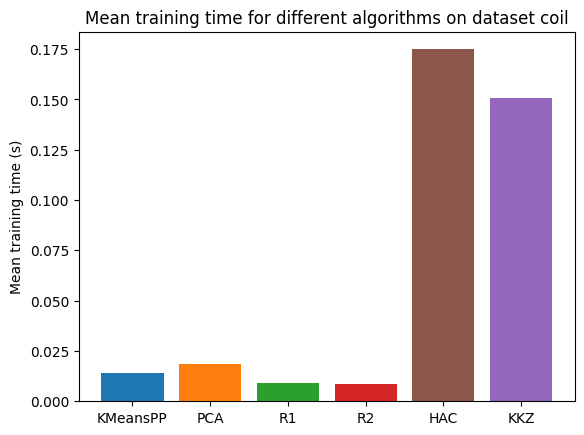

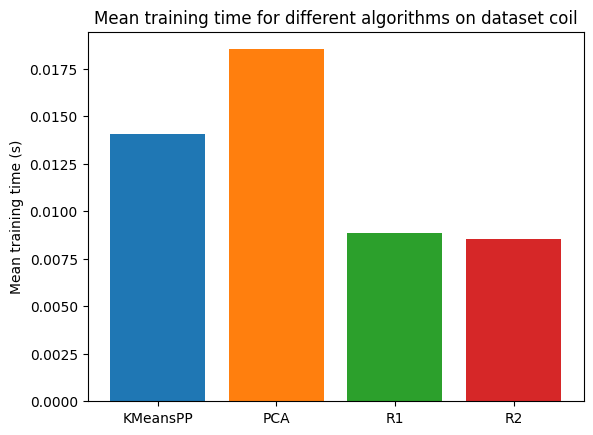

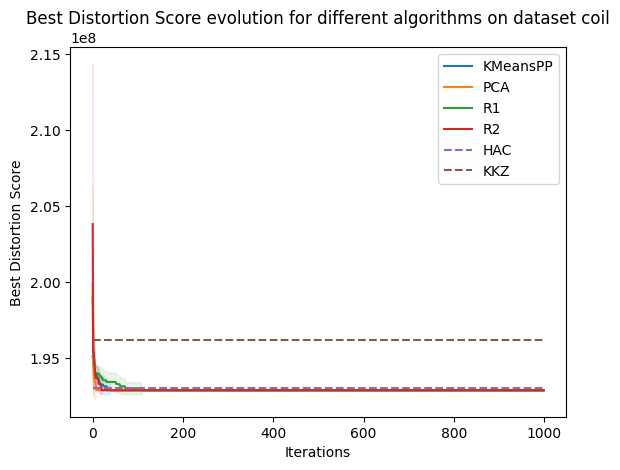

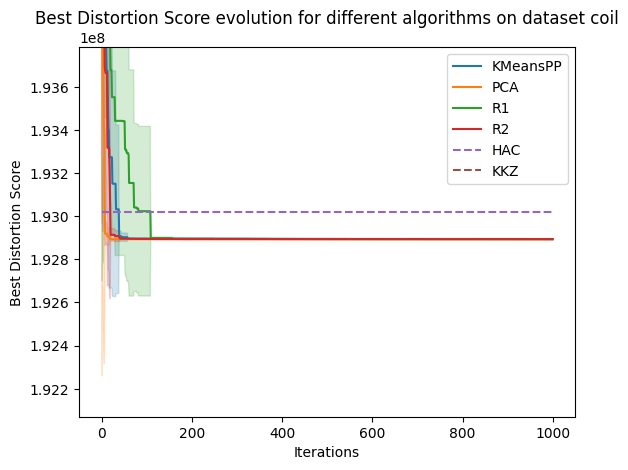

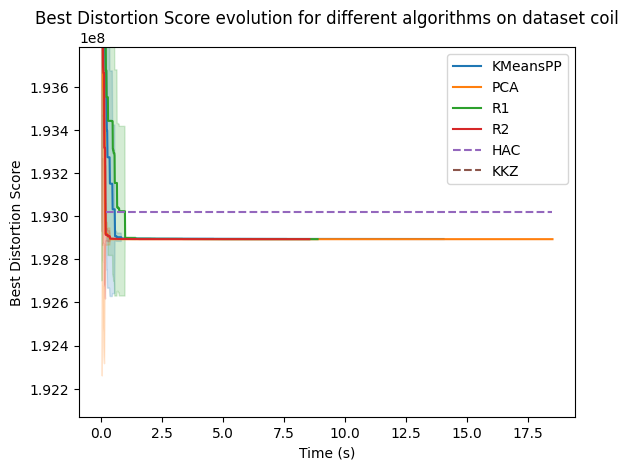

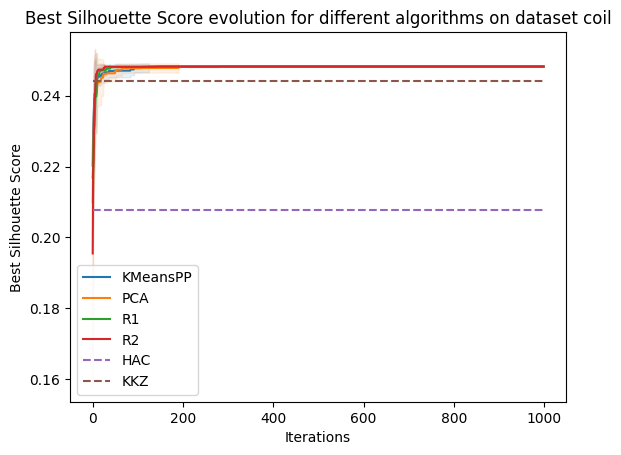

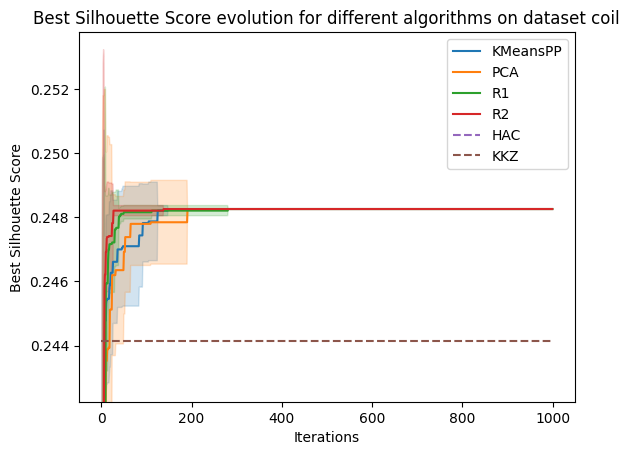

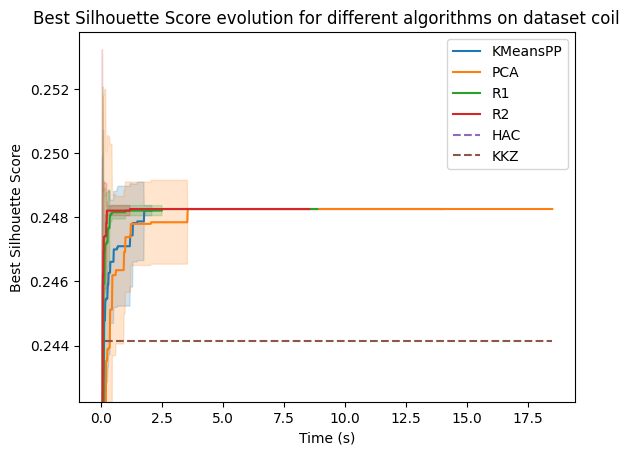

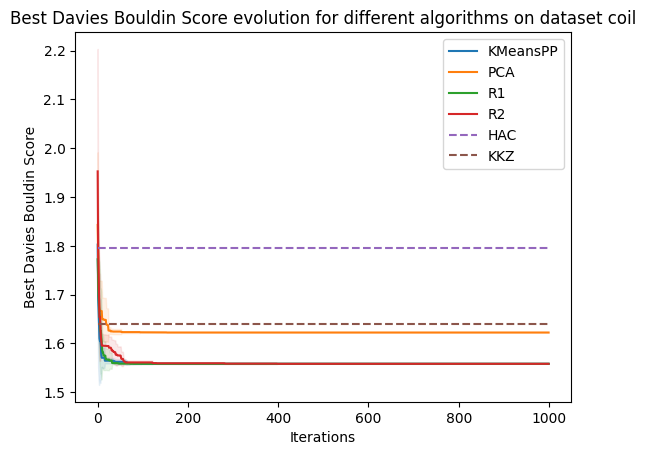

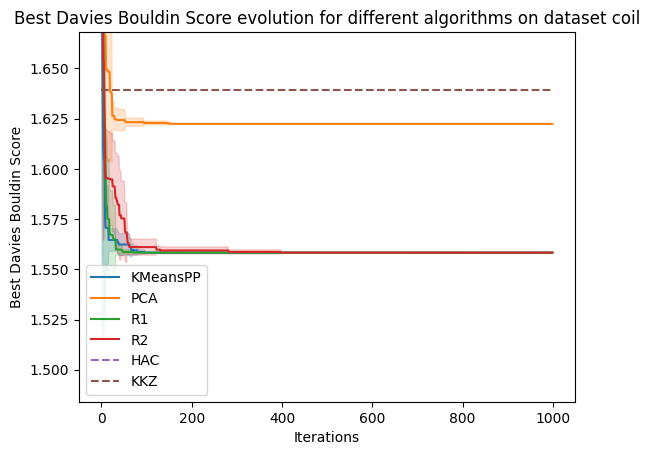

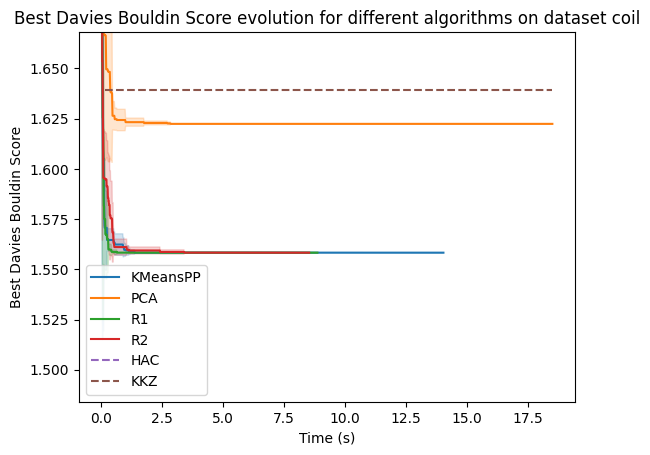

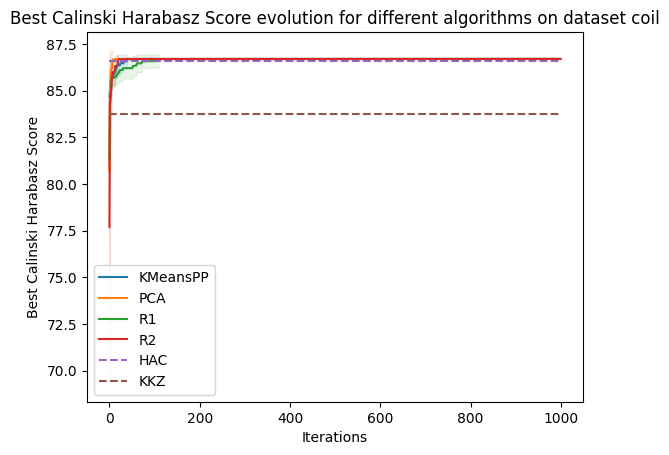

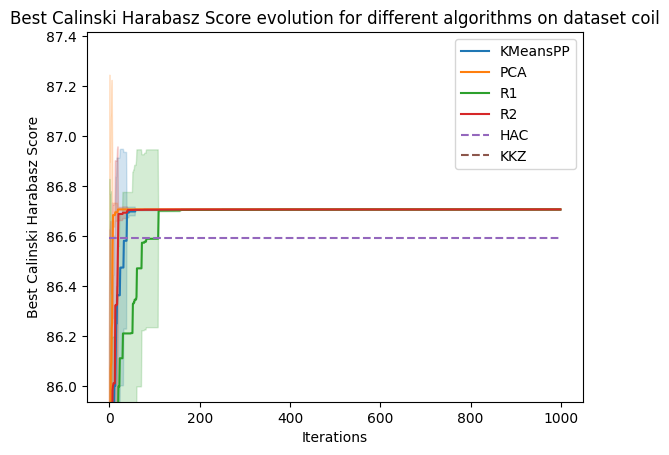

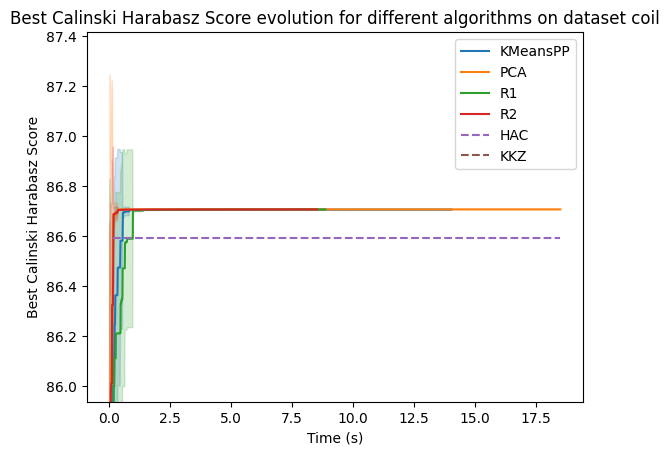

Dataset: iris
Number of runs: 42
Number of iterations: [1000, 1000, 1000, 1000, 1, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


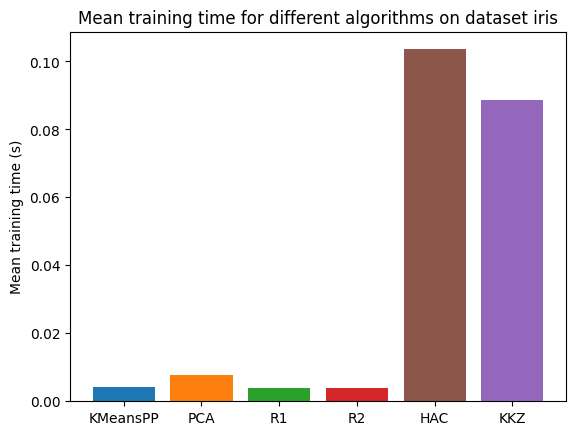

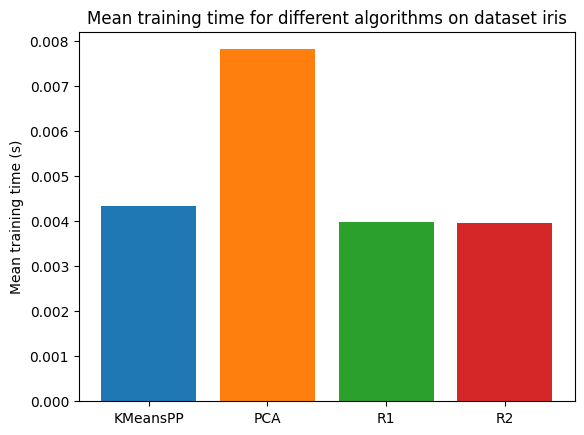

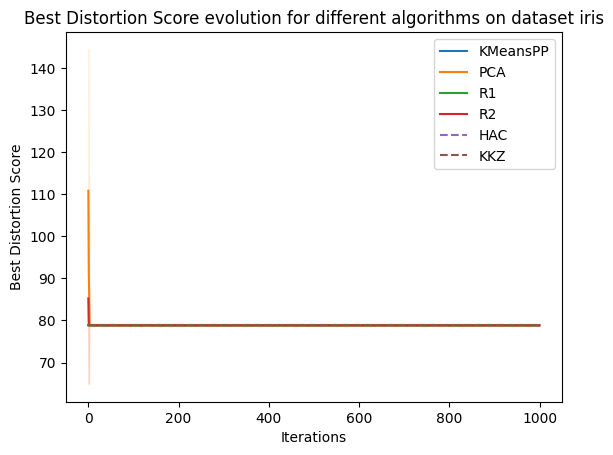

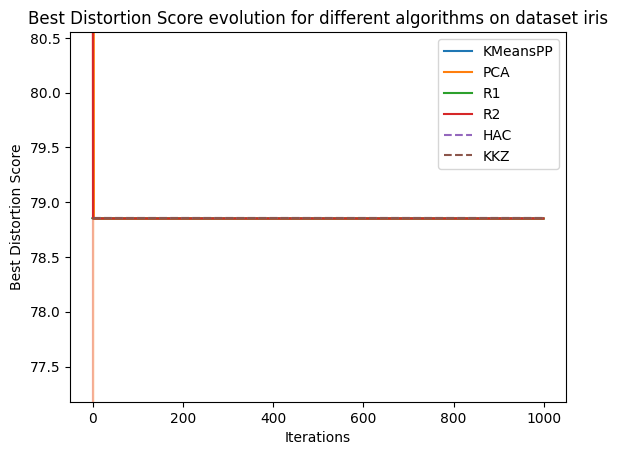

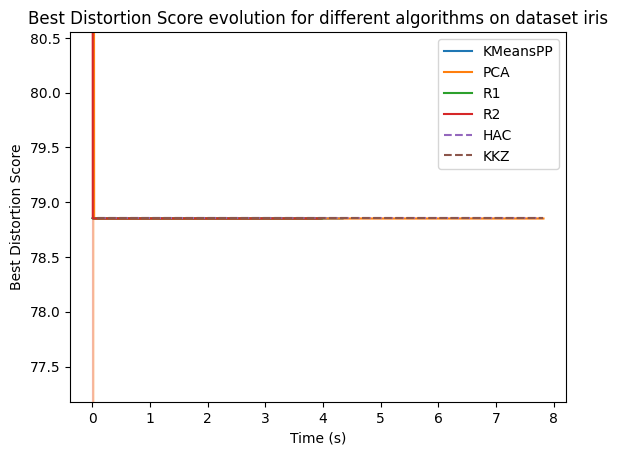

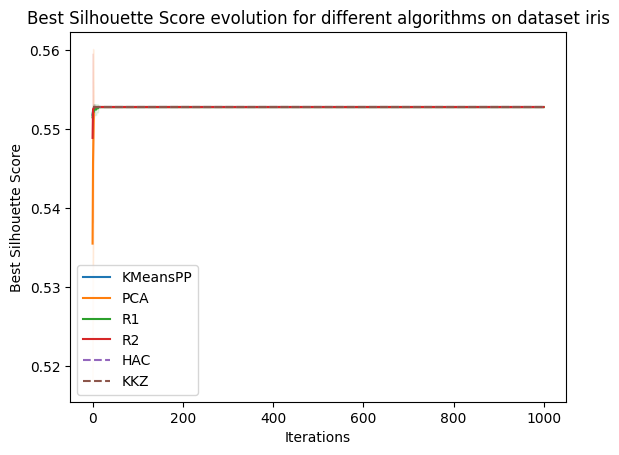

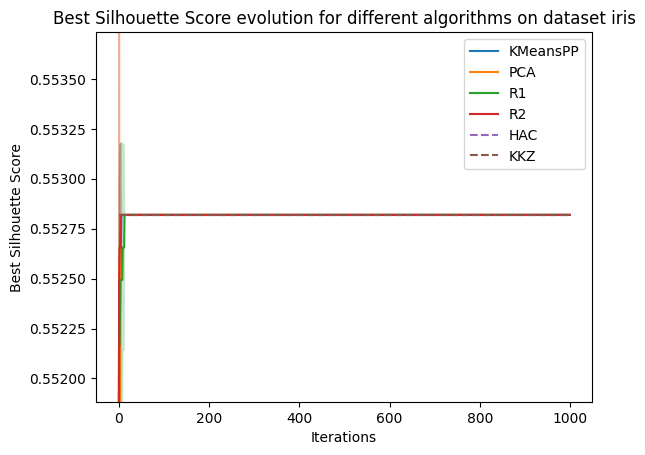

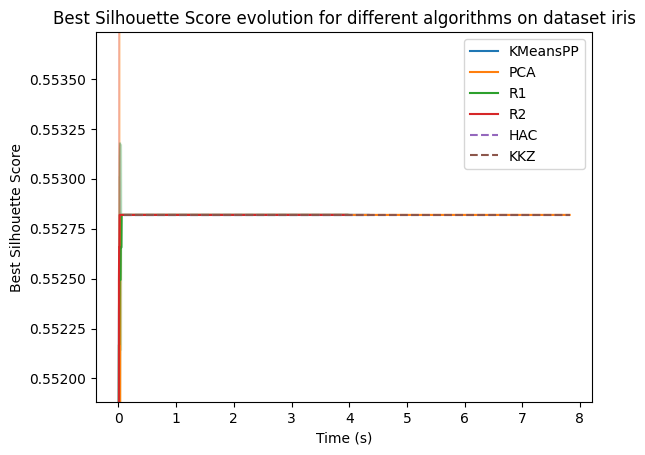

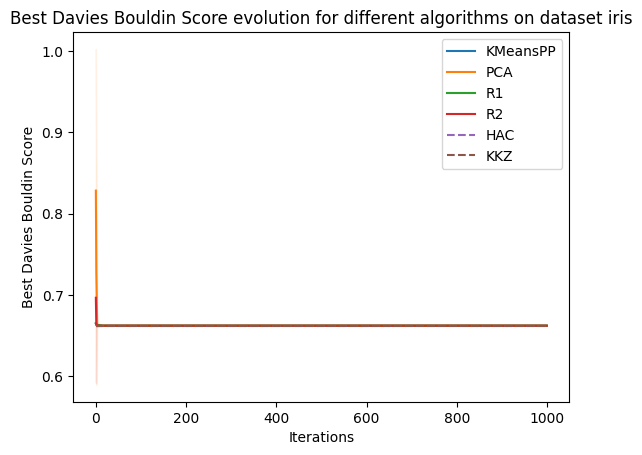

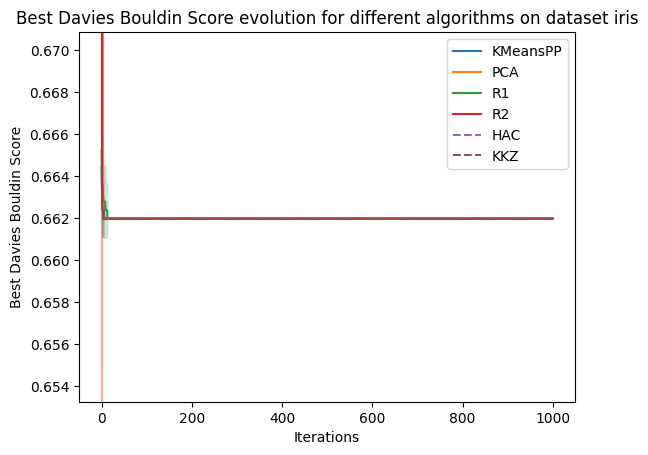

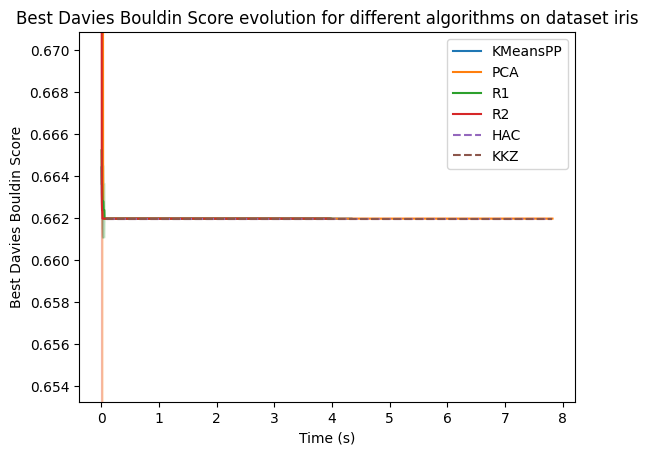

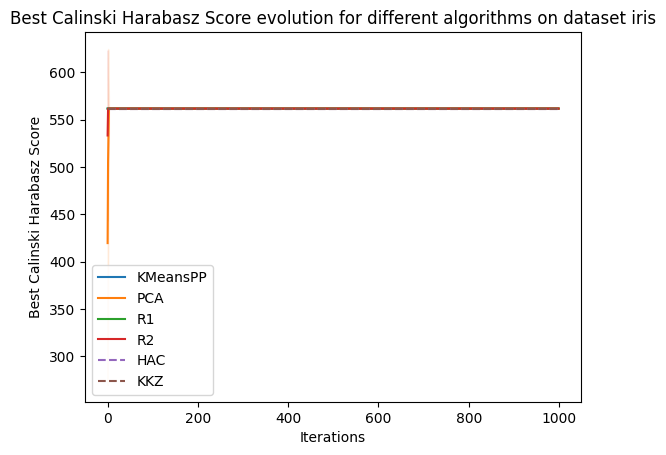

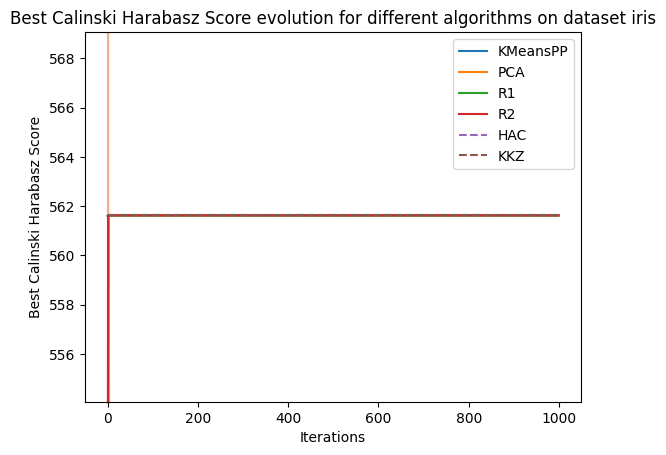

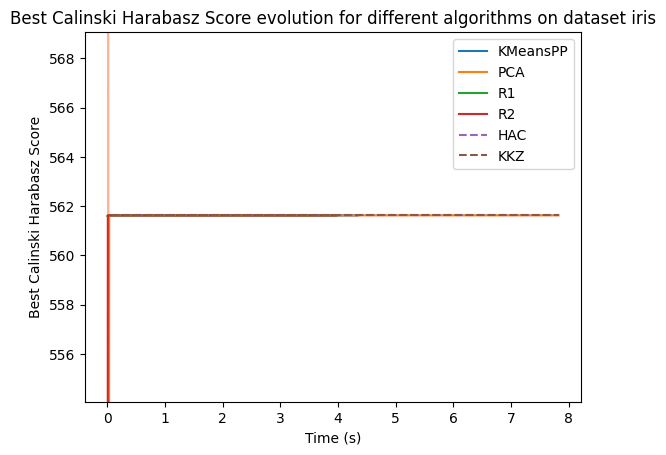

Dataset: mnist
Number of runs: 42
Number of iterations: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


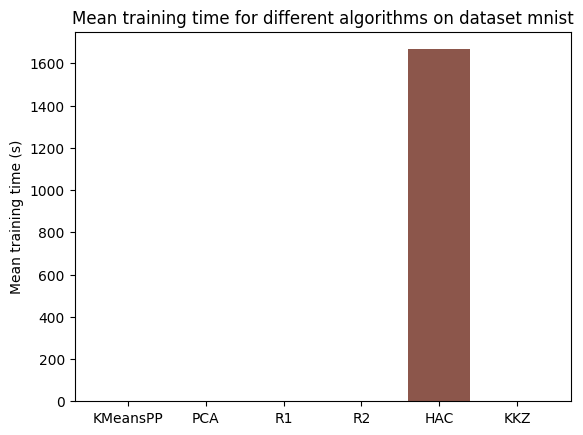

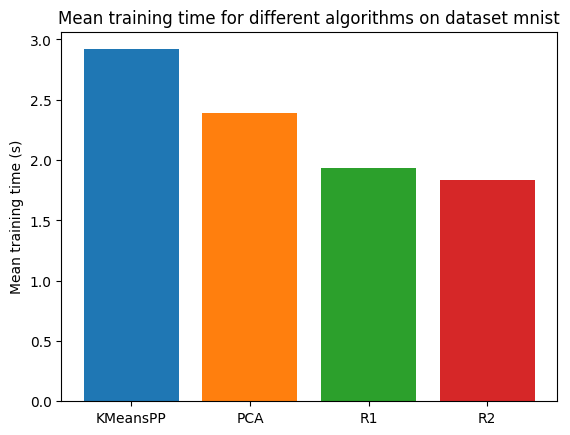

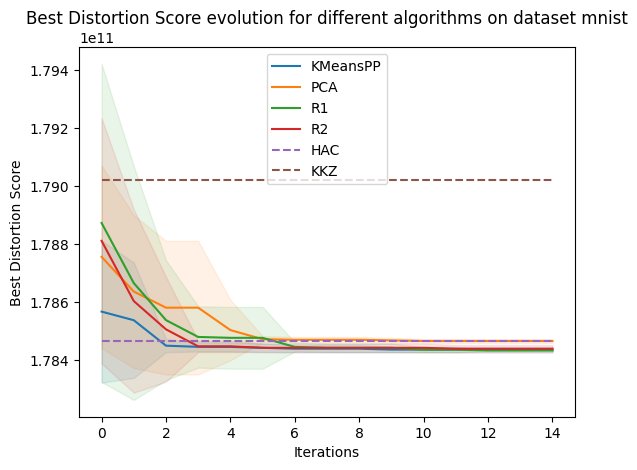

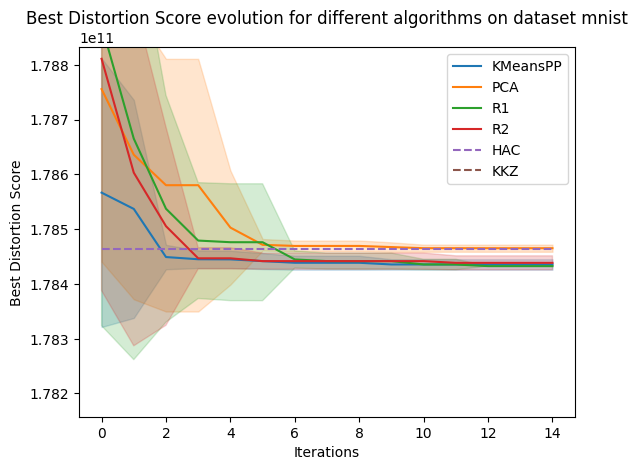

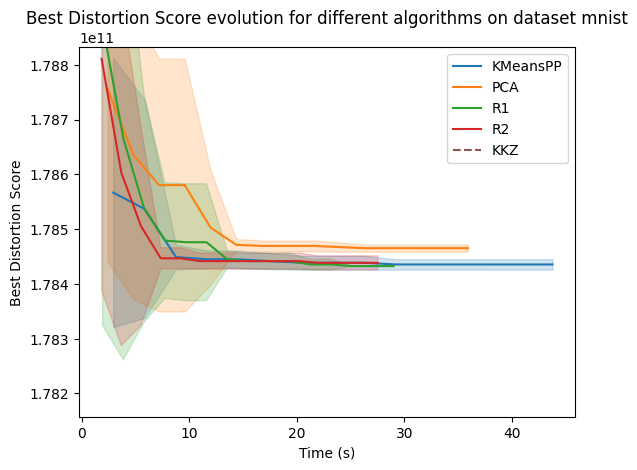

In [21]:
plot_dataset(datasets[0])
plot_dataset(datasets[1])
plot_dataset(datasets[2])
plot_dataset(datasets[3])
plot_dataset(datasets[4])
plot_dataset(datasets[5])

In [38]:
df = all_runs.groupby(["algorithm", "dataset"])["time_training"].mean().unstack()
df

dataset,att,ba,cifar10,coil,iris,mnist
algorithm,,,,,,
SK_HAC,0.625015,0.249934,15053.753548,0.174886,0.103555,1666.247611
SK_KKZ,0.796886,0.203121,11.086628,0.150699,0.088625,3.089922
SK_KMeansPP,0.832745,0.055515,9.910506,0.014043,0.004337,2.918672
SK_PCA_GuidedSearch,0.191566,0.033387,4.283789,0.018513,0.007821,2.394191
SK_R1,0.123043,0.010354,5.453957,0.008872,0.003984,1.933340
SK_R2,0.092636,0.009025,5.194777,0.008533,0.003961,1.835418


In [47]:
df_q3 = all_runs.groupby(["algorithm", "dataset"])["distortion"].quantile(0.75).unstack()
df_q3 = df_q3.fillna(0)
df_q1 = all_runs.groupby(["algorithm", "dataset"])["distortion"].quantile(0.25).unstack()
df_q1 = df_q1.fillna(0)

distortion = (df_q3 - df_q1) / (df_q3 + df_q1)
distortion = distortion.fillna(0)
# change order of columns
distortion = distortion[["iris", "ba", "att", "coil", "mnist", "cifar10"]]
distortion

dataset,iris,ba,att,coil,mnist,cifar10
algorithm,,,,,,
SK_HAC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SK_KKZ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SK_KMeansPP,0.000027,0.002717,0.007456,0.006449,0.001625,0.000371
SK_PCA_GuidedSearch,0.000027,0.002684,0.011003,0.012152,0.001497,0.000400
SK_R1,0.000000,0.003324,0.013361,0.012666,0.001608,0.000490
SK_R2,0.000027,0.003291,0.012911,0.027535,0.001863,0.000373
